In [1]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore", category=DeprecationWarning)
from mpl_toolkits.basemap import Basemap
import missingno as msno
import matplotlib.pylab as pylab
import gmplot
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import Imputer
import numpy as np
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
sns.set(style="whitegrid", color_codes=True)
pylab.rcParams['figure.figsize'] = 16, 12
pd.options.mode.chained_assignment = None
%matplotlib inline


C:\Users\sugan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train_2017.csv') #this data includes log error and parcel ID of year 2017
prop = pd.read_csv('properties_2017.csv') #this data includes log error and parcel ID of year 2017
train.head()

C:\Users\sugan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


parcelid  logerror transactiondate
0  14297519  0.025595      2017-01-01
1  17052889  0.055619      2017-01-01
2  14186244  0.005383      2017-01-01
3  12177905 -0.103410      2017-01-01
4  10887214  0.006940      2017-01-01

### chaging the data types of the given data

In [3]:
categorical = ['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'fips', 'hashottuborspa',
               'propertycountylandusecode', 'propertyzoningdesc', 'rawcensustractandblock', 'censustractandblock', 'regionidcounty', 'regionidcity',
               'regionidzip', 'regionidneighborhood','buildingqualitytypeid', 'decktypeid', 'heatingorsystemtypeid', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 
     'propertylandusetypeid', 'storytypeid', 'typeconstructiontypeid', 'taxdelinquencyflag', 'taxdelinquencyyear']
for col in categorical:
    prop[col] =prop[col].astype('category')
train['transactiondate'] = pd.to_datetime(train['transactiondate'])

##### Renaming the columns

In [4]:
data_dict = pd.read_excel('zillow_data_dictionary.xlsx', parse_cols="A:B")
features = data_dict['Feature'].apply(lambda x:x.strip("'")) 
data_dict['Feature'] = features
d = {} #forming a dictionary to rename columns
for a,b in data_dict.iterrows():
    d[b['Feature']] = b['Rename']

#Rename Columns
prop.rename_axis(d,axis=1,inplace=True)

#Making a copy of data frame for future analysis purpose
prop_copy = prop.copy()

### Merging the house attributes data  and house transaction data

In [6]:
merge_df = prop.merge(train, how ='inner')
total_df = prop.merge(train, how = 'left')
total_df['transactiondate'] = pd.to_datetime(total_df['transactiondate'])

In [8]:
merge_df['transactiondate'] = pd.to_datetime(merge_df['transactiondate'])
merge_df['month']=merge_df['transactiondate'].dt.month
merge_df['day'] = merge_df['transactiondate'].dt.day
merge_df['quarter'] = merge_df['transactiondate'].dt.quarter
merge_df['transaction_year'] = merge_df['transactiondate'].dt.year
merge_df['age'] = 2017 - merge_df['yearbuilt']
merge_df['month'] = merge_df['month'].astype('category')
merge_df['quarter'] = merge_df['quarter'].astype('category')


### View of the data

In [9]:
merge_df.head()

parcelid ac_type arch_Type  basementsqft  total_bathcnt  bedroomcnt  \
0  17054981     NaN       NaN           NaN            5.0         4.0   
1  17055743     NaN       NaN           NaN            2.0         3.0   
2  17068109     NaN       NaN           NaN            1.5         3.0   
3  17073952     NaN       NaN           NaN            2.0         2.0   
4  17078502     NaN       NaN           NaN            1.0         2.0   

  building_class building_quality  calculatedbathnbr decktypeid  ...   \
0            NaN              NaN                5.0        NaN  ...    
1            NaN              NaN                2.0       66.0  ...    
2            NaN              NaN                1.5       66.0  ...    
3            NaN              NaN                2.0        NaN  ...    
4            NaN              NaN                1.0        NaN  ...    

   taxdelinquencyflag  taxdelinquencyyear  censustractandblock  logerror  \
0                 NaN                 NaN         6.111001e+13 -0.013099   
1                 NaN                 NaN         6.111001e+13  0.073985   
2                 NaN                 NaN         6.111001e+13  0.071886   
3                 NaN                 NaN         6.111002e+13  0.305680   
4                 NaN                 NaN         6.111002e+13 -0.073787   

   transactiondate  month  day quarter  transaction_year   age  
0       2017-06-15      6   15       2              2017  35.0  
1       2017-07-26      7   26       3              2017  66.0  
2       2017-07-28      7   28       3              2017  38.0  
3       2017-06-02      6    2       2              2017  28.0  
4       2017-07-07      7    7       3              2017  69.0  

[5 rows x 65 columns]

- Data consists of 64 columns and we can see that Null values are present we have to process the data to remove them

In [10]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Data columns (total 65 columns):
parcelid                      77613 non-null int64
ac_type                       25007 non-null category
arch_Type                     207 non-null category
basementsqft                  50 non-null float64
total_bathcnt                 77579 non-null float64
bedroomcnt                    77579 non-null float64
building_class                15 non-null category
building_quality              49809 non-null category
calculatedbathnbr             76963 non-null float64
decktypeid                    614 non-null category
firstfloor_finisharea         6037 non-null float64
total_finisharea              77378 non-null float64
finished_living               73923 non-null float64
perimeter_living              42 non-null float64
total_area                    3027 non-null float64
firstfloor_finisharea         6037 non-null float64
basetotalarea                 386 non-null float64
fips 

#### Descriptive Statistics (count, mean, std, min, Max) of numerical attributes in the the data

In [11]:
merge_df.describe()

parcelid  basementsqft  total_bathcnt    bedroomcnt  \
count  7.761300e+04     50.000000   77579.000000  77579.000000   
mean   1.300781e+07    679.720000       2.298496      3.053223   
std    3.518717e+06    689.703546       0.996732      1.140480   
min    1.071186e+07     38.000000       0.000000      0.000000   
25%    1.153821e+07    273.000000       2.000000      2.000000   
50%    1.253004e+07    515.000000       2.000000      3.000000   
75%    1.421101e+07    796.500000       3.000000      4.000000   
max    1.676893e+08   3560.000000      18.000000     16.000000   

       calculatedbathnbr  firstfloor_finisharea  total_finisharea  \
count       76963.000000            6037.000000      77378.000000   
mean            2.316392            1366.165314       1784.935421   
std             0.979689             670.701336        954.250373   
min             1.000000              44.000000        128.000000   
25%             2.000000             955.000000       1182.000000   
50%             2.000000            1257.000000       1542.000000   
75%             3.000000            1615.000000       2112.000000   
max            18.000000            6912.000000      35640.000000   

       finished_living  perimeter_living    total_area      ...       \
count     73923.000000         42.000000   3027.000000      ...        
mean       1760.284553       1388.761905   2354.491245      ...        
std         934.352566        122.220874   1186.985442      ...        
min         128.000000       1056.000000    598.000000      ...        
25%        1172.000000       1344.000000   1624.000000      ...        
50%        1523.000000       1440.000000   2088.000000      ...        
75%        2075.000000       1440.000000   2831.000000      ...        
max       21929.000000       1560.000000  35640.000000      ...        

       numberofstories  structuretaxvaluedollarcnt      totaltax  \
count     17599.000000                7.746400e+04  7.757800e+04   
mean          1.434286                1.892811e+05  4.901506e+05   
std           0.544515                2.304107e+05  6.537979e+05   
min           1.000000                4.400000e+01  1.000000e+03   
25%           1.000000                8.417925e+04  2.068985e+05   
50%           1.000000                1.364045e+05  3.588785e+05   
75%           2.000000                2.187340e+05  5.690000e+05   
max           6.000000                1.142179e+07  4.906124e+07   

       assessmentyear  landtaxvaluedollarcnt     taxperyear      logerror  \
count         77579.0           7.757700e+04   77574.000000  77613.000000   
mean           2016.0           3.011515e+05    5995.961788      0.016755   
std               0.0           4.927249e+05    7628.859728      0.170887   
min            2016.0           1.610000e+02      19.920000     -4.655420   
25%            2016.0           8.529300e+04    2712.630000     -0.024325   
50%            2016.0           2.031880e+05    4448.265000      0.006670   
75%            2016.0           3.667530e+05    6926.917500      0.039295   
max            2016.0           4.895220e+07  586639.300000      5.262999   

                day  transaction_year           age  
count  77613.000000           77613.0  77309.000000  
mean      16.524629            2017.0     48.388493  
std        8.959493               0.0     23.793171  
min        1.000000            2017.0      1.000000  
25%        9.000000            2017.0     30.000000  
50%       17.000000            2017.0     47.000000  
75%       24.000000            2017.0     64.000000  
max       31.000000            2017.0    193.000000  

[8 rows x 37 columns]

#### Percentage and Graphical analysis of Null values in the data

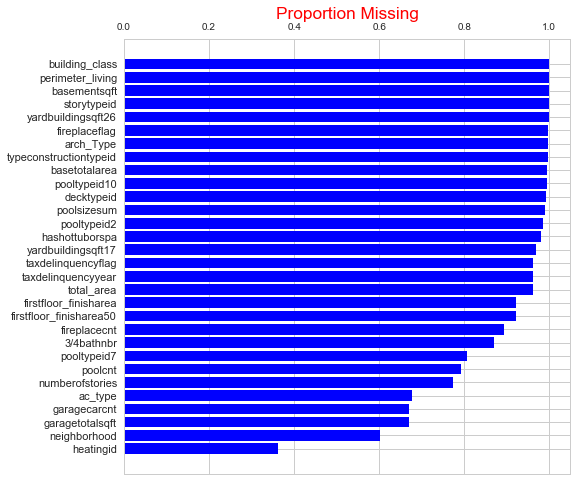

In [104]:
total_nulls = merge_df.isnull().sum().sort_values(ascending = False)
percent = ((merge_df.isnull().sum().sort_values())/(len(merge_df))).sort_values(ascending = False)
missin_val = pd.concat([total_nulls, percent], axis = 1, keys =['Total', 'Percent_missing'])
missin_val.sort_values('Percent_missing', ascending = False)
missin_val.reset_index(inplace=True)
missin_val.rename({'index': 'Column_name'})
missin_val.sort_values(by= ['Percent_missing'], axis = 0, ascending = True, inplace=True)
missin_val.head()
plt.figure(figsize=(8,8))
plt.barh(bottom= np.arange(30), width= missin_val.Percent_missing.values[35:], tick_label = missin_val['index'].values[35:], color = 'blue')
plt.xlabel('Proportion Missing', fontsize = 'xx-large', color = 'red')
plt.tick_params(axis = 'y', labelsize =11.0)
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.savefig('missing_values')


##### visualizing the Null values in a dataframe Graphically 

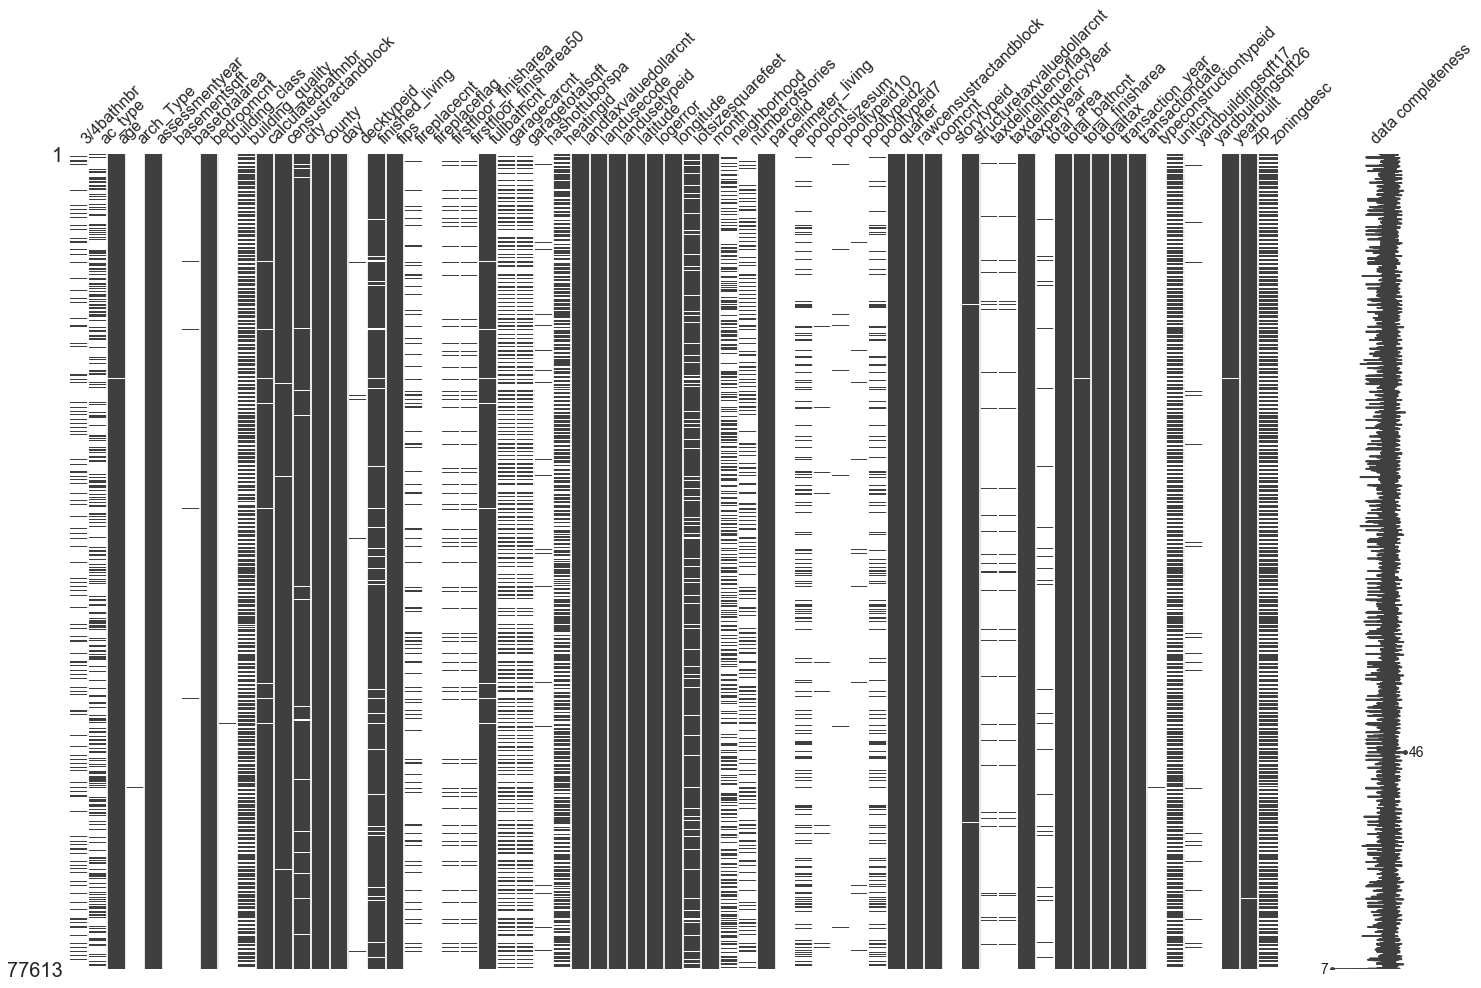

In [106]:
merge_df = merge_df.reindex_axis(sorted(merge_df.columns), axis=1) 
msno.matrix(merge_df, figsize= (24, 15), labels = True, width_ratios=(15,1))

In [12]:
## For Exploratory data analysis i am not including the log error values which are below 1 percent and above 99 percent
nomerge_df = merge_df[(merge_df['logerror']  < np.percentile(merge_df['logerror'], 99)) & (merge_df['logerror'] > np.percentile(merge_df['logerror'], 1))]
omerge_df = merge_df[~((merge_df['logerror']  < np.percentile(merge_df['logerror'], 99)) & (merge_df['logerror'] > np.percentile(merge_df['logerror'], 1)))]

#### Zestimate (log error) analysis

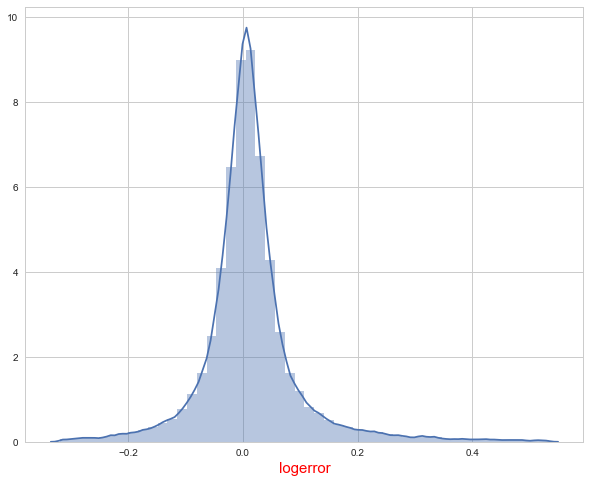

In [13]:
plt.figure(figsize = (10,8))
ax1 = sns.distplot(nomerge_df.logerror.values)
ax1.set_xlabel('logerror', size =15, color = 'red')


In [14]:
merge_df['abs_logerror']= merge_df.logerror.abs()
nomerge_df['abs_logerror']= nomerge_df.logerror.abs()
omerge_df['abs_logerror']= merge_df.logerror.abs()


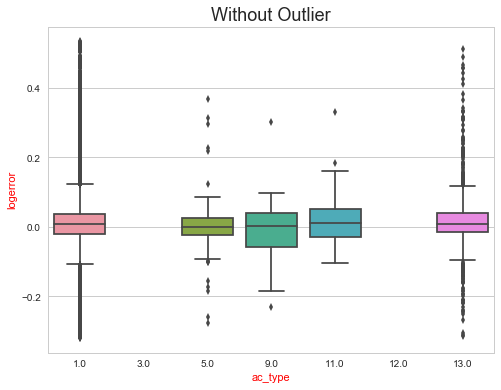

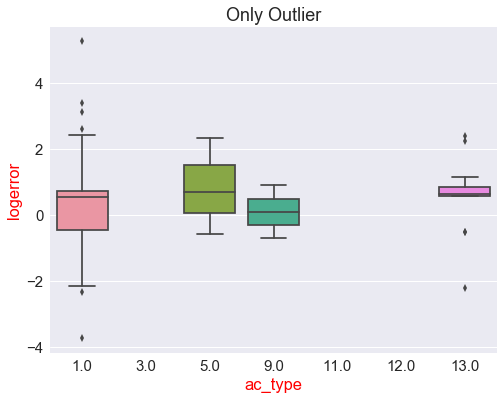

In [15]:
plt.figure(figsize=(8, 6))
g = sns.boxplot(x = nomerge_df['ac_type'], y= nomerge_df['logerror'])
sns.set(font_scale=1.5)
g.set_xlabel(g.get_xlabel(), color = 'red')
g.set_ylabel(g.get_ylabel(), color ='red')
g.set_title('Without Outlier')

# --------------------------------------------------------------------
plt.figure(figsize=(8, 6))
g = sns.boxplot(x = omerge_df['ac_type'], y= omerge_df['logerror'])
sns.set(font_scale=1.5)
g.set_xlabel(g.get_xlabel(), color = 'red')
g.set_ylabel(g.get_ylabel(), color ='red')
g.set_title('Only Outlier')

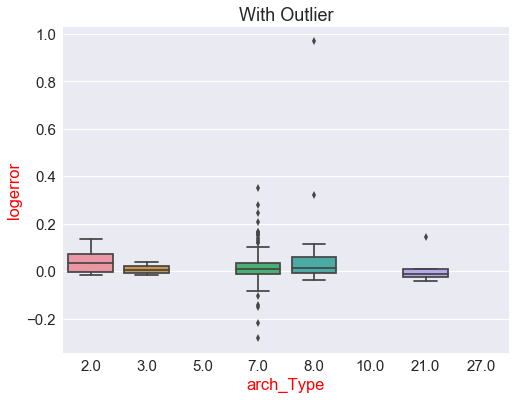

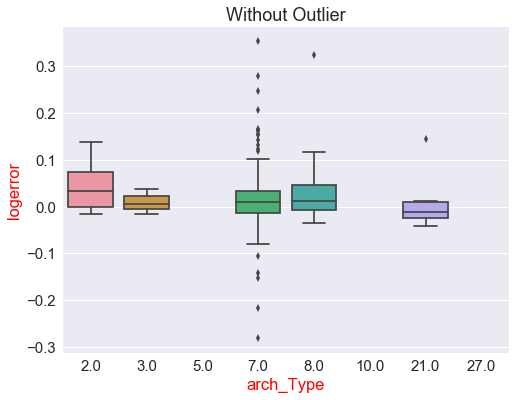

In [111]:
plt.figure(figsize=(8, 6))
g = sns.boxplot(x = merge_df['arch_Type'], y= merge_df['logerror'])
sns.set(font_scale=1.5)
g.set_xlabel(g.get_xlabel(), color = 'red')
g.set_ylabel(g.get_ylabel(), color ='red')
g.set_title('With Outlier')

#--------------------------------------------
plt.figure(figsize=(8, 6))
g = sns.boxplot(x = nomerge_df['arch_Type'], y= nomerge_df['logerror'])
sns.set(font_scale=1.5)
g.set_xlabel(g.get_xlabel(), color = 'red')
g.set_ylabel(g.get_ylabel(), color ='red')
g.set_title('Without Outlier')

In [112]:
categorical_cols = merge_df.dtypes[merge_df.dtypes == 'category'].index.tolist()
categorical_cols

['ac_type',
 'arch_Type',
 'building_class',
 'building_quality',
 'censustractandblock',
 'city',
 'county',
 'decktypeid',
 'fips',
 'hashottuborspa',
 'heatingid',
 'landusecode',
 'landusetypeid',
 'month',
 'neighborhood',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'quarter',
 'rawcensustractandblock',
 'storytypeid',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'typeconstructiontypeid',
 'zip',
 'zoningdesc']

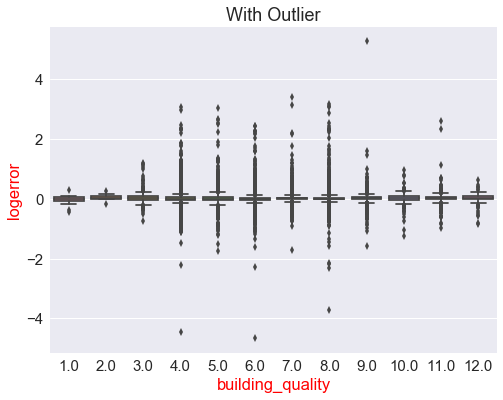

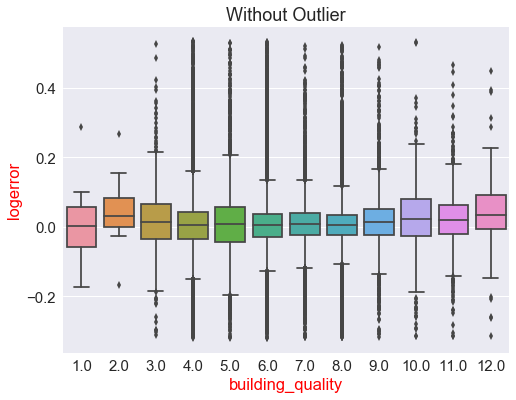

In [113]:
plt.figure(figsize=(8, 6))
g = sns.boxplot(x = merge_df['building_quality'], y= merge_df['logerror'])
sns.set(font_scale=1.5)
g.set_xlabel(g.get_xlabel(), color = 'red')
g.set_ylabel(g.get_ylabel(), color ='red')
g.set_title('With Outlier')

#--------------------------------------------
plt.figure(figsize=(8, 6))
g = sns.boxplot(x = nomerge_df['building_quality'], y= nomerge_df['logerror'])
sns.set(font_scale=1.5)
g.set_xlabel(g.get_xlabel(), color = 'red')
g.set_ylabel(g.get_ylabel(), color ='red')
g.set_title('Without Outlier')

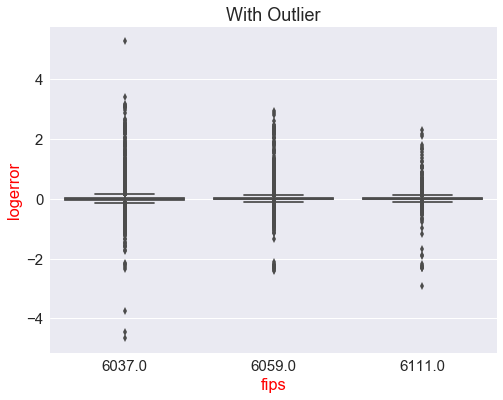

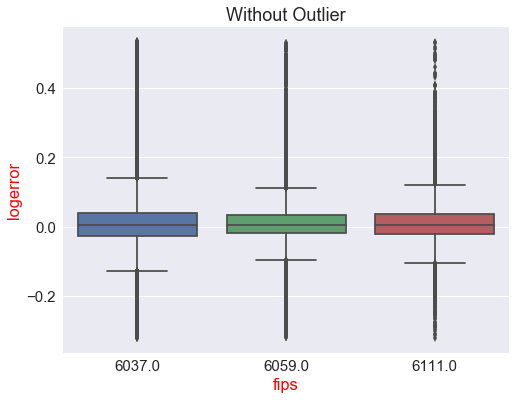

In [114]:
plt.figure(figsize=(8, 6))
g = sns.boxplot(x = merge_df['fips'], y= merge_df['logerror'])
sns.set(font_scale=1.5)
g.set_xlabel(g.get_xlabel(), color = 'red')
g.set_ylabel(g.get_ylabel(), color ='red')
g.set_title('With Outlier')

#--------------------------------------------
plt.figure(figsize=(8, 6))
g = sns.boxplot(x = nomerge_df['fips'], y= nomerge_df['logerror'])
sns.set(font_scale=1.5)
g.set_xlabel(g.get_xlabel(), color = 'red')
g.set_ylabel(g.get_ylabel(), color ='red')
g.set_title('Without Outlier')

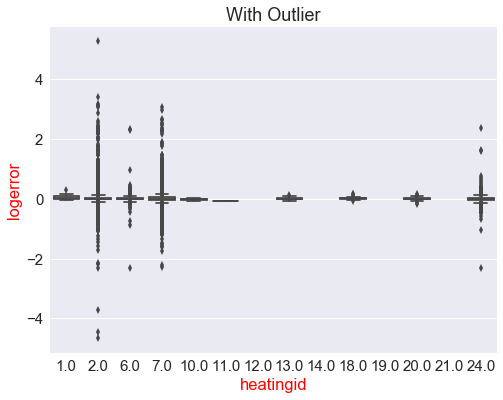

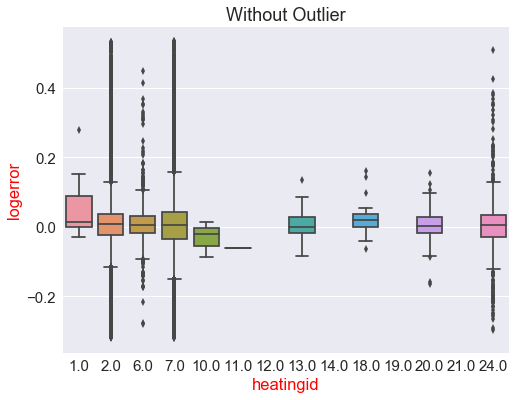

In [115]:
plt.figure(figsize=(8, 6))
g = sns.boxplot(x = merge_df['heatingid'], y= merge_df['logerror'])
sns.set(font_scale=1.5)
g.set_xlabel(g.get_xlabel(), color = 'red')
g.set_ylabel(g.get_ylabel(), color ='red')
g.set_title('With Outlier')

#--------------------------------------------
plt.figure(figsize=(8, 6))
g = sns.boxplot(x = nomerge_df['heatingid'], y= nomerge_df['logerror'])
sns.set(font_scale=1.5)
g.set_xlabel(g.get_xlabel(), color = 'red')
g.set_ylabel(g.get_ylabel(), color ='red')
g.set_title('Without Outlier')

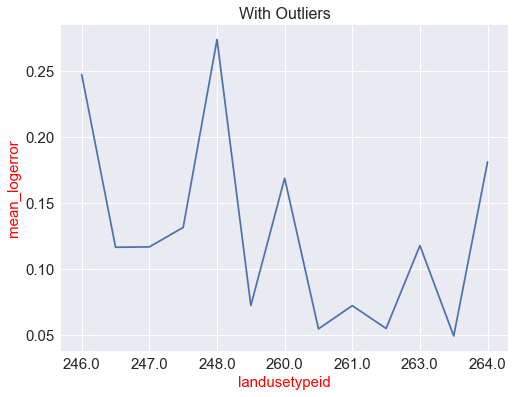

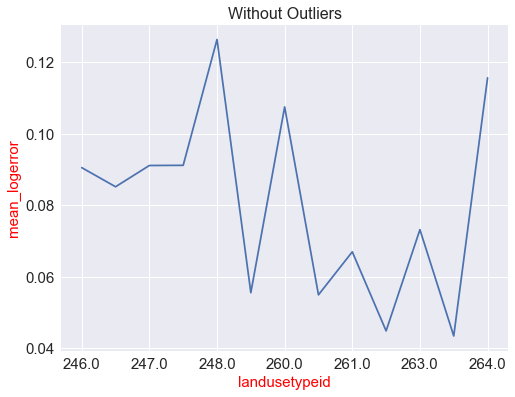

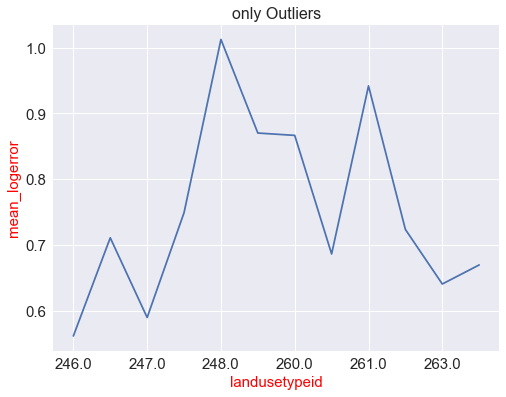

In [116]:
bools = merge_df.groupby(by='landusetypeid').mean()['abs_logerror'].notnull()
plt.figure(figsize = (8,6))
plt.plot(merge_df.groupby(by='landusetypeid').mean()['abs_logerror'][bools].values)
ax1 = plt.gca()
ax1.set_xticklabels(merge_df.groupby(by='landusetypeid').mean()['abs_logerror'][bools].index.tolist(), size = 'small')
ax1.set_xlabel('landusetypeid', size ='small', color = 'red')
ax1.set_ylabel('mean_logerror', size ='small', color = 'red')
plt.title('With Outliers', fontsize = 16)

#-------------------------------------------------------------------------------------------
bools = nomerge_df.groupby(by='landusetypeid').mean()['abs_logerror'].notnull()
plt.figure(figsize = (8,6))
plt.plot(nomerge_df.groupby(by='landusetypeid').mean()['abs_logerror'][bools].values)
ax1 = plt.gca()
ax1.set_xticklabels(nomerge_df.groupby(by='landusetypeid').mean()['abs_logerror'][bools].index.tolist(), size = 'small')
ax1.set_xlabel('landusetypeid', size ='small', color = 'red')
ax1.set_ylabel('mean_logerror', size ='small', color = 'red')
plt.title('Without Outliers', fontsize = 16)

#-------------------------------------------------------------------------------------------------
bools = omerge_df.groupby(by='landusetypeid').mean()['abs_logerror'].notnull()
plt.figure(figsize = (8,6))
plt.plot(omerge_df.groupby(by='landusetypeid').mean()['abs_logerror'][bools].values)
ax1 = plt.gca()
ax1.set_xticklabels(omerge_df.groupby(by='landusetypeid').mean()['abs_logerror'][bools].index.tolist(), size = 'small')
ax1.set_xlabel('landusetypeid', size ='small', color = 'red')
ax1.set_ylabel('mean_logerror', size ='small', color = 'red')
plt.title('only Outliers', fontsize = 16)

(array([ -50.,    0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.]),
 <a list of 9 Text xticklabel objects>)

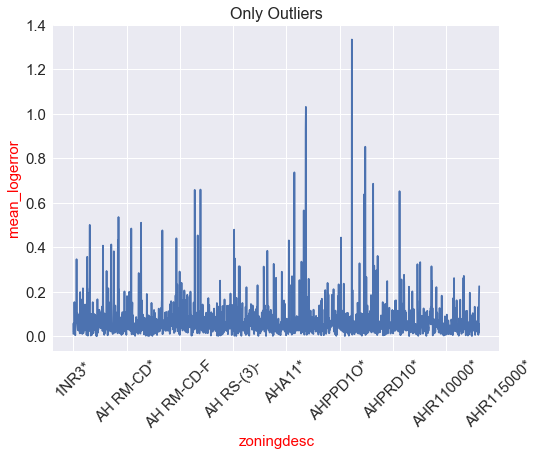

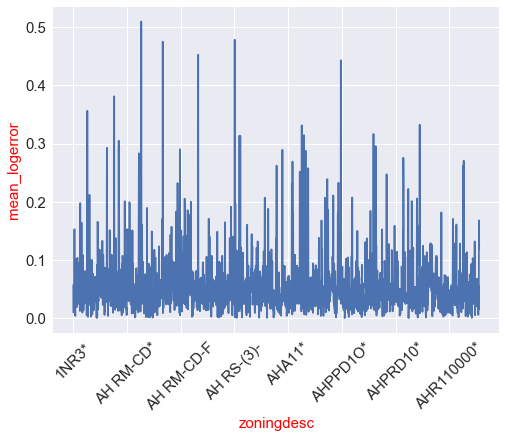

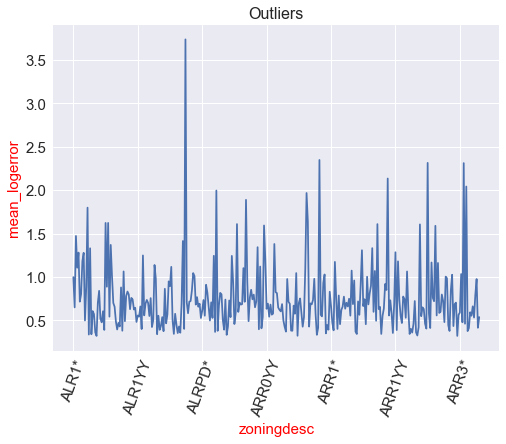

In [117]:
bools = merge_df.groupby(by='zoningdesc').mean()['abs_logerror'].notnull()
plt.figure(figsize = (8,6))
plt.plot(merge_df.groupby(by='zoningdesc').mean()['abs_logerror'][bools].values)
ax1 = plt.gca()
ax1.set_xticklabels(merge_df.groupby(by='zoningdesc').mean()['abs_logerror'][bools].index.tolist(), size = 'small')
ax1.set_xlabel('zoningdesc', size ='small', color = 'red')
ax1.set_ylabel('mean_logerror', size ='small', color = 'red')
plt.title('With Outliers', fontsize = 16)
plt.title('Only Outliers', fontsize = 16)
plt.xticks(rotation=45)


#-------------------------------------------------------------------------------------------
bools = nomerge_df.groupby(by='zoningdesc').mean()['abs_logerror'].notnull()
plt.figure(figsize = (8,6))
plt.plot(nomerge_df.groupby(by='zoningdesc').mean()['abs_logerror'][bools].values)
ax1 = plt.gca()
ax1.set_xticklabels(nomerge_df.groupby(by='zoningdesc').mean()['abs_logerror'][bools].index.tolist(), size = 'small')
ax1.set_xlabel('zoningdesc', size ='small', color = 'red')
ax1.set_ylabel('mean_logerror', size ='small', color = 'red')
plt.xticks(rotation=45)

#-------------------------------------------------------------------------------------------------
bools = omerge_df.groupby(by='zoningdesc').mean()['abs_logerror'].notnull()
plt.figure(figsize = (8,6))
plt.plot(omerge_df.groupby(by='zoningdesc').mean()['abs_logerror'][bools].values)
ax1 = plt.gca()
ax1.set_xticklabels(omerge_df.groupby(by='zoningdesc').mean()['abs_logerror'][bools].index.tolist(), size = 'small')
ax1.set_xlabel('zoningdesc', size ='small', color = 'red')
ax1.set_ylabel('mean_logerror', size ='small', color = 'red')
plt.title('Outliers', fontsize = 16)
plt.xticks(rotation=70)

(array([ -20.,    0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.]),
 <a list of 10 Text xticklabel objects>)

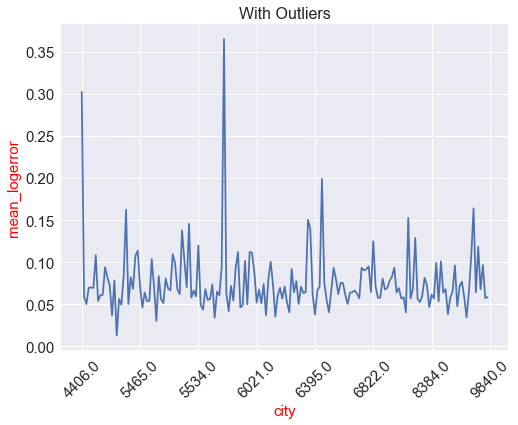

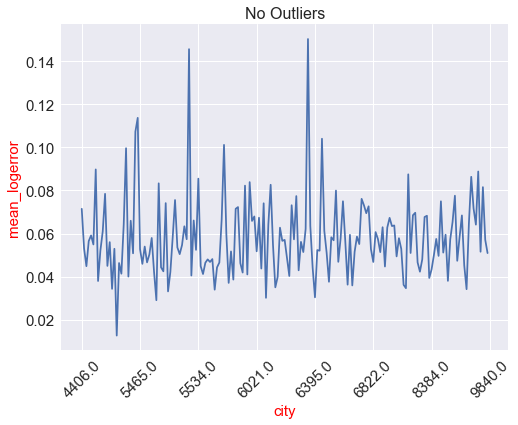

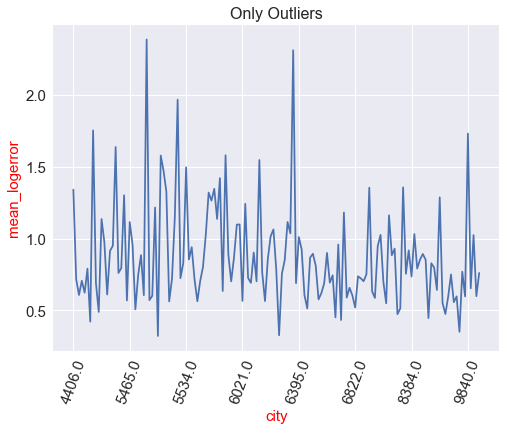

In [118]:
bools = merge_df.groupby(by='city').mean()['abs_logerror'].notnull()
plt.figure(figsize = (8,6))
plt.plot(merge_df.groupby(by='city').mean()['abs_logerror'][bools].values)
ax1 = plt.gca()
ax1.set_xticklabels(merge_df.groupby(by='city').mean()['abs_logerror'][bools].index.tolist(), size = 'small')
ax1.set_xlabel('city', size ='small', color = 'red')
ax1.set_ylabel('mean_logerror', size ='small', color = 'red')
plt.title('With Outliers', fontsize = 16)
plt.xticks(rotation=45)


#-------------------------------------------------------------------------------------------
bools = nomerge_df.groupby(by='city').mean()['abs_logerror'].notnull()
plt.figure(figsize = (8,6))
plt.plot(nomerge_df.groupby(by='city').mean()['abs_logerror'][bools].values)
ax1 = plt.gca()
ax1.set_xticklabels(nomerge_df.groupby(by='city').mean()['abs_logerror'][bools].index.tolist(), size = 'small')
ax1.set_xlabel('city', size ='small', color = 'red')
ax1.set_ylabel('mean_logerror', size ='small', color = 'red')
plt.title('No Outliers', fontsize = 16)
plt.xticks(rotation=45)

#-------------------------------------------------------------------------------------------------
bools = omerge_df.groupby(by='city').mean()['abs_logerror'].notnull()
plt.figure(figsize = (8,6))
plt.plot(omerge_df.groupby(by='city').mean()['abs_logerror'][bools].values)
ax1 = plt.gca()
ax1.set_xticklabels(omerge_df.groupby(by='city').mean()['abs_logerror'][bools].index.tolist(), size = 'small')
ax1.set_xlabel('city', size ='small', color = 'red')
ax1.set_ylabel('mean_logerror', size ='small', color = 'red')
plt.title('Only Outliers', fontsize = 16)
plt.xticks(rotation=70)

(array([ -50.,    0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.]),
 <a list of 10 Text xticklabel objects>)

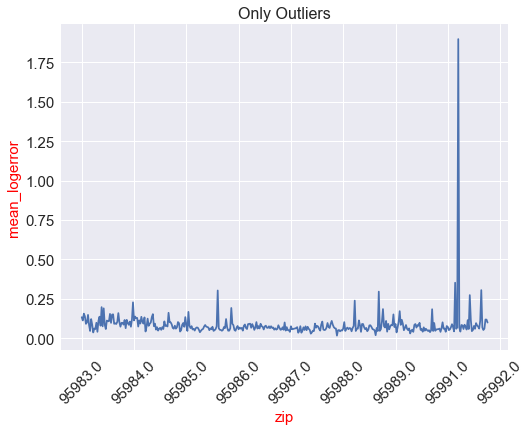

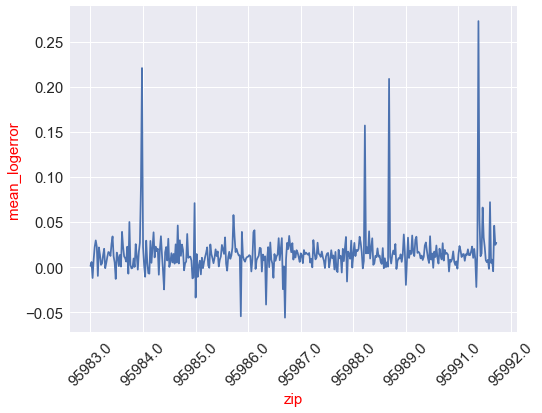

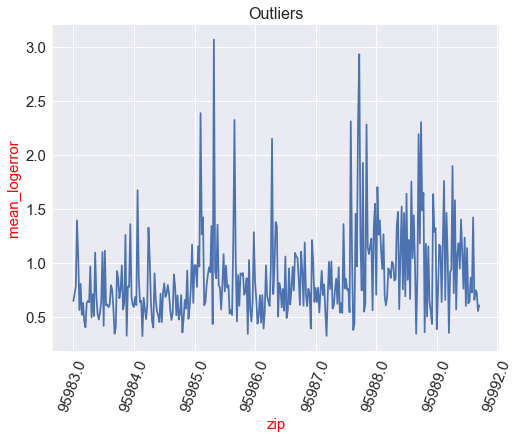

In [119]:
bools = merge_df.groupby(by='zip').mean()['abs_logerror'].notnull()
plt.figure(figsize = (8,6))
plt.plot(merge_df.groupby(by='zip').mean()['abs_logerror'][bools].values)
ax1 = plt.gca()
ax1.set_xticklabels(merge_df.groupby(by='zip').mean()['abs_logerror'][bools].index.tolist(), size = 'small')
ax1.set_xlabel('zip', size ='small', color = 'red')
ax1.set_ylabel('mean_logerror', size ='small', color = 'red')
plt.title('With Outliers', fontsize = 16)
plt.title('Only Outliers', fontsize = 16)
plt.xticks(rotation=45)


#-------------------------------------------------------------------------------------------
bools = nomerge_df.groupby(by='zip').mean()['logerror'].notnull()
plt.figure(figsize = (8,6))
plt.plot(nomerge_df.groupby(by='zip').mean()['logerror'][bools].values)
ax1 = plt.gca()
ax1.set_xticklabels(nomerge_df.groupby(by='zip').mean()['logerror'][bools].index.tolist(), size = 'small')
ax1.set_xlabel('zip', size ='small', color = 'red')
ax1.set_ylabel('mean_logerror', size ='small', color = 'red')
plt.xticks(rotation=45)

#-------------------------------------------------------------------------------------------------
bools = omerge_df.groupby(by='zip').mean()['abs_logerror'].notnull()
plt.figure(figsize = (8,6))
plt.plot(omerge_df.groupby(by='zip').mean()['abs_logerror'][bools].values)
ax1 = plt.gca()
ax1.set_xticklabels(omerge_df.groupby(by='zip').mean()['abs_logerror'][bools].index.tolist(), size = 'small')
ax1.set_xlabel('zip', size ='small', color = 'red')
ax1.set_ylabel('mean_logerror', size ='small', color = 'red')
plt.title('Outliers', fontsize = 16)
plt.xticks(rotation=70)

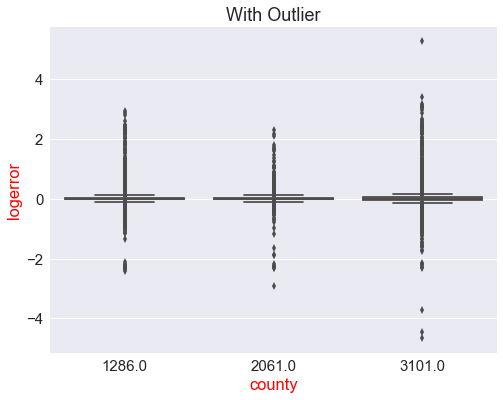

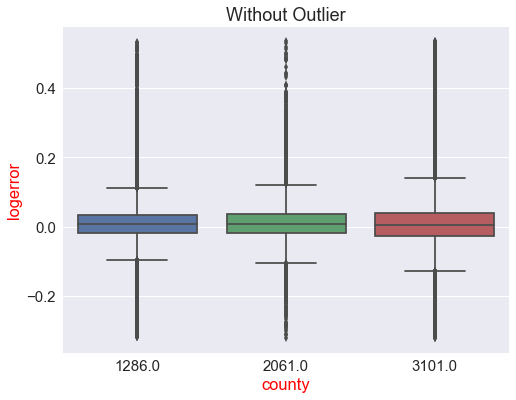

In [120]:
plt.figure(figsize=(8, 6))
g = sns.boxplot(x = merge_df['county'], y= merge_df['logerror'])
sns.set(font_scale=1.5)
g.set_xlabel(g.get_xlabel(), color = 'red')
g.set_ylabel(g.get_ylabel(), color ='red')
g.set_title('With Outlier')

#--------------------------------------------
plt.figure(figsize=(8, 6))
g = sns.boxplot(x = nomerge_df['county'], y= nomerge_df['logerror'])
sns.set(font_scale=1.5)
g.set_xlabel(g.get_xlabel(), color = 'red')
g.set_ylabel(g.get_ylabel(), color ='red')
g.set_title('Without Outlier')

### from the above analysis unnecessary category attributes are removed 

- if they have large number of null values (90% of values being null)
- no deivation in the mean log error with the category and standar deviation being same
- attributes which give same amount of information ( for examples, city and zip code provide insights to same information )

In [16]:
copy_merge_df = merge_df.copy() #making a copy of dataframe before altering it
copy_nomerge_df = nomerge_df.copy()
copy_omerge_df = omerge_df.copy()

In [17]:
copy_merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Data columns (total 66 columns):
parcelid                      77613 non-null int64
ac_type                       25007 non-null category
arch_Type                     207 non-null category
basementsqft                  50 non-null float64
total_bathcnt                 77579 non-null float64
bedroomcnt                    77579 non-null float64
building_class                15 non-null category
building_quality              49809 non-null category
calculatedbathnbr             76963 non-null float64
decktypeid                    614 non-null category
firstfloor_finisharea         6037 non-null float64
total_finisharea              77378 non-null float64
finished_living               73923 non-null float64
perimeter_living              42 non-null float64
total_area                    3027 non-null float64
firstfloor_finisharea         6037 non-null float64
basetotalarea                 386 non-null float64
fips 

In [18]:
merge_df.drop(['landusecode', 'building_class', 'decktypeid', 'fips', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'county',
              'typeconstructiontypeid', 'storytypeid', 'taxdelinquencyflag', 'taxdelinquencyyear', 'zip', 'neighborhood'], axis = 1, inplace =True)
nomerge_df.drop(['landusecode', 'building_class', 'decktypeid', 'fips', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'county',
              'typeconstructiontypeid', 'storytypeid', 'taxdelinquencyflag', 'taxdelinquencyyear', 'zip', 'neighborhood'], axis = 1, inplace =True)
omerge_df.drop(['landusecode', 'building_class', 'decktypeid', 'fips', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'county',
              'typeconstructiontypeid', 'storytypeid', 'taxdelinquencyflag', 'taxdelinquencyyear', 'zip', 'neighborhood'], axis = 1, inplace =True)

## Numerical attribute analysis

In [19]:
numerical_col = merge_df.dtypes[(merge_df.dtypes =='int64')|(merge_df.dtypes =='float64')].index.tolist()

In [20]:
merge_df[numerical_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Data columns (total 40 columns):
parcelid                      77613 non-null int64
basementsqft                  50 non-null float64
total_bathcnt                 77579 non-null float64
bedroomcnt                    77579 non-null float64
calculatedbathnbr             76963 non-null float64
firstfloor_finisharea         6037 non-null float64
firstfloor_finisharea         6037 non-null float64
total_finisharea              77378 non-null float64
finished_living               73923 non-null float64
perimeter_living              42 non-null float64
total_area                    3027 non-null float64
firstfloor_finisharea         6037 non-null float64
firstfloor_finisharea         6037 non-null float64
basetotalarea                 386 non-null float64
fireplacecnt                  8289 non-null float64
fullbathcnt                   76963 non-null float64
garagecarcnt                  25520 non-null float64
garage

In [21]:
numerical_col

['parcelid',
 'basementsqft',
 'total_bathcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'firstfloor_finisharea',
 'total_finisharea',
 'finished_living',
 'perimeter_living',
 'total_area',
 'firstfloor_finisharea',
 'basetotalarea',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'roomcnt',
 '3/4bathnbr',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'numberofstories',
 'structuretaxvaluedollarcnt',
 'totaltax',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxperyear',
 'logerror',
 'day',
 'transaction_year',
 'age',
 'abs_logerror']

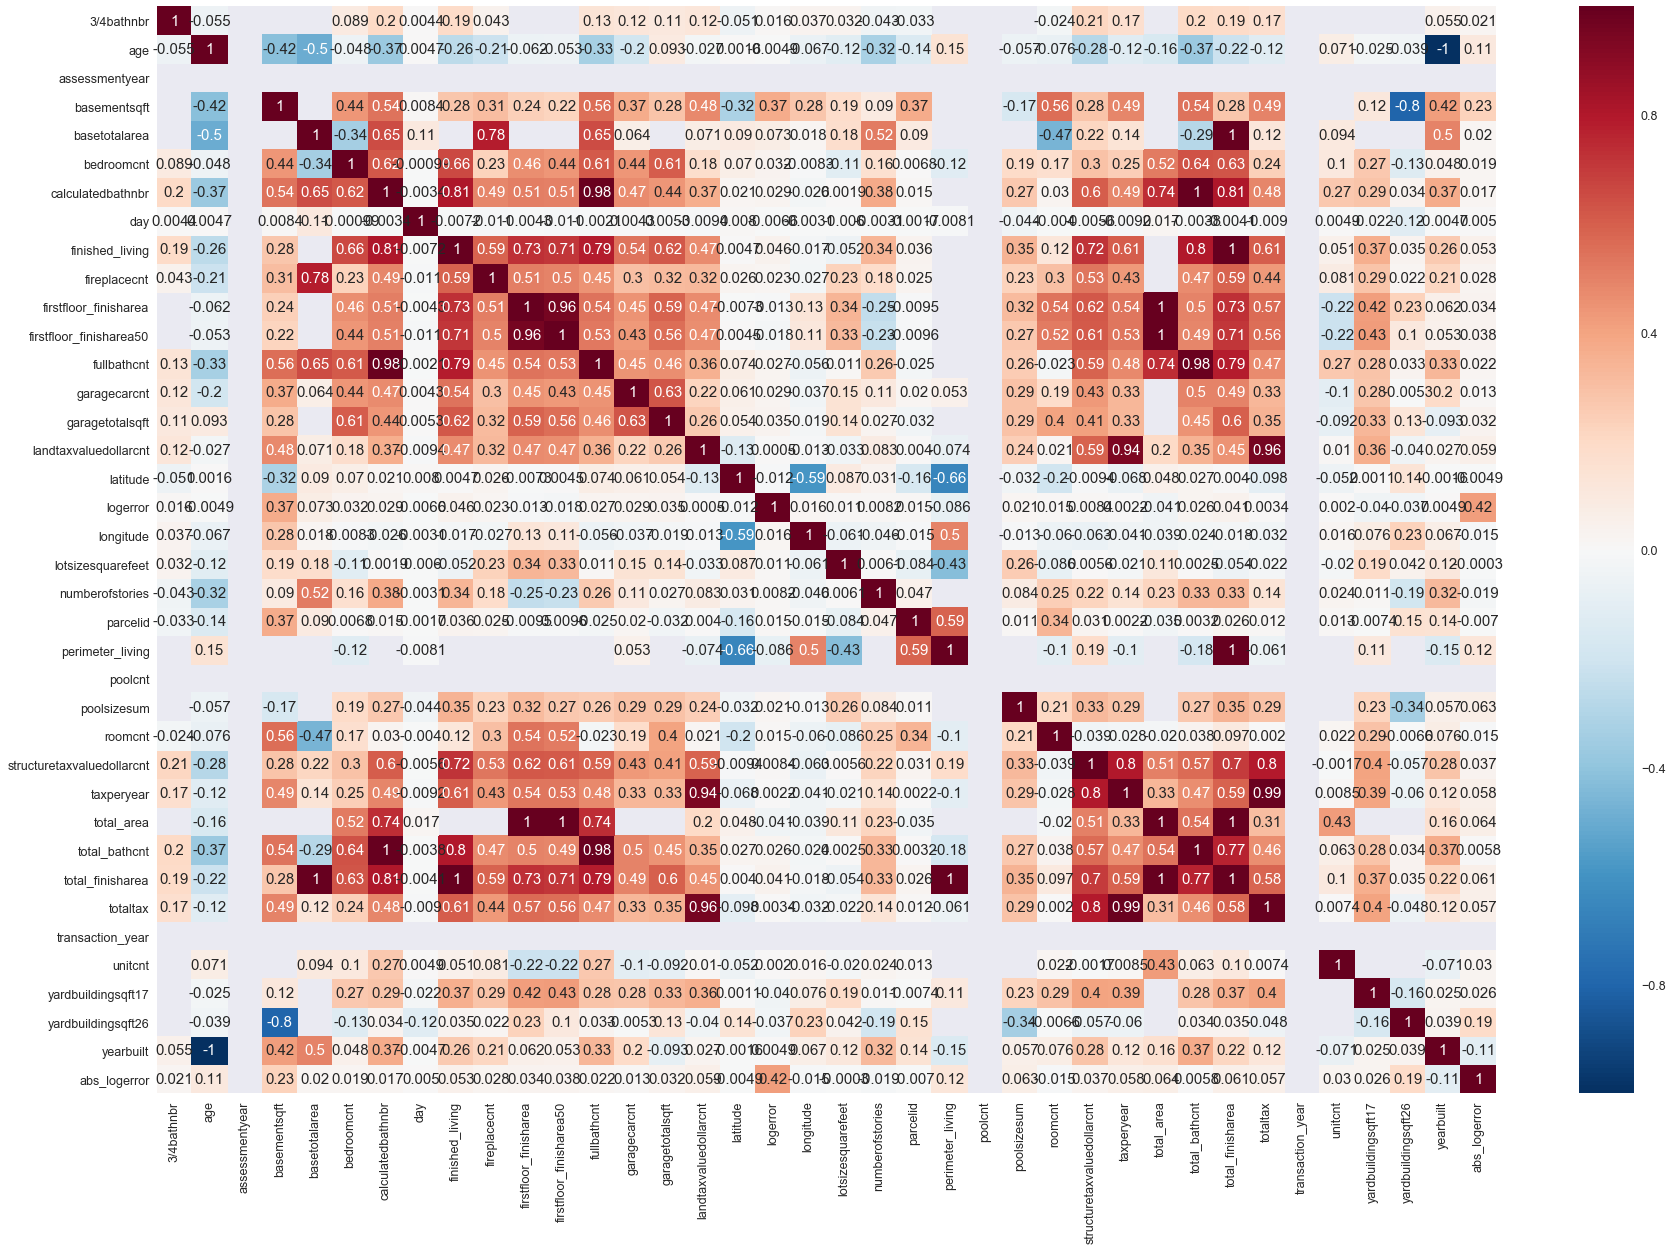

In [127]:
corr_mat = merge_df.corr()
plt.figure(figsize = (30, 20))
sns.set(font_scale = 1.25)
sns.heatmap(corr_mat, annot = True)

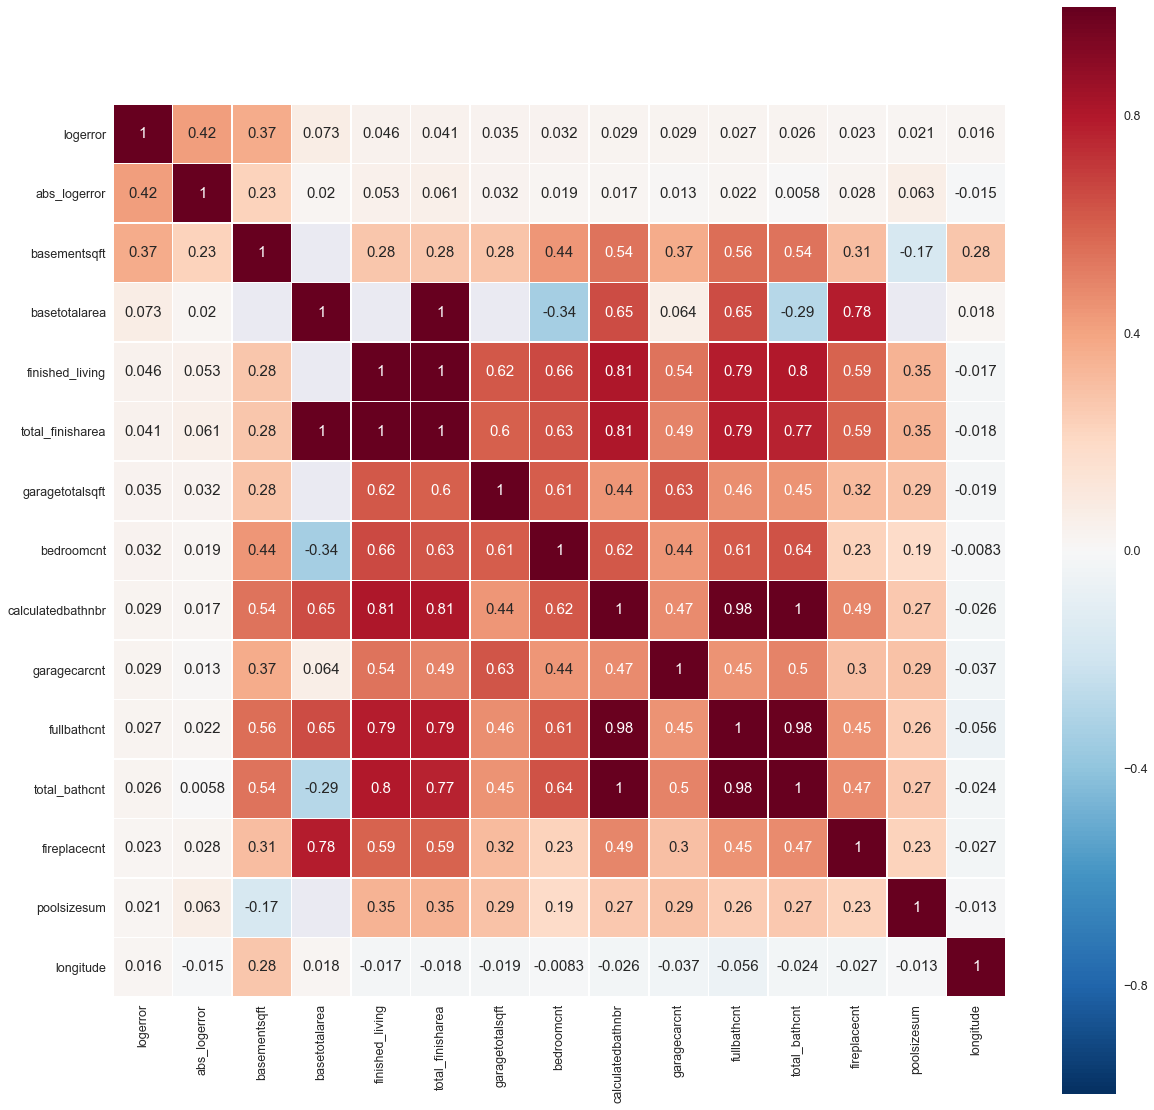

In [128]:
#coorelation matrix arranged in descending order of correlation with log error
cols = corr_mat.nlargest(15, 'logerror')['logerror'].index
plt.figure(figsize= (20,20))
coor_mat_10 = merge_df[cols].corr()
sns.heatmap(coor_mat_10, square = True, annot=True, linewidths =0.5)
sns.set_style(style = 'darkgrid')
sns.set(font_scale = 1)

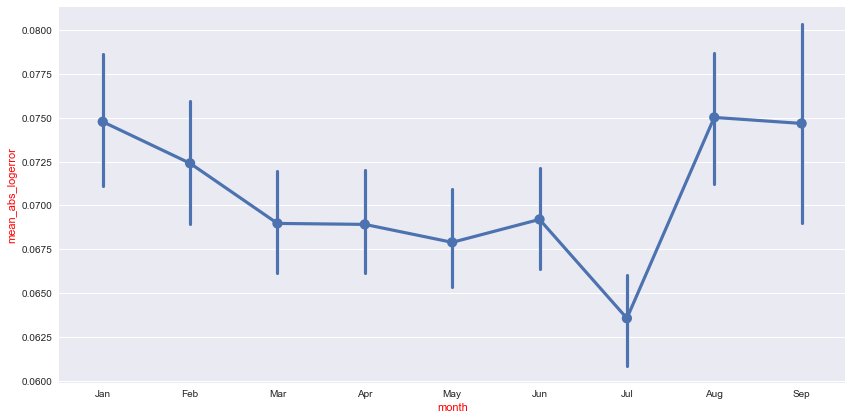

In [129]:
plt.figure(figsize=(8, 6))
g = sns.factorplot(x = 'month', y= 'abs_logerror', data= merge_df, estimator= np.mean, size = 6, aspect=2)
sns.set(font_scale=1.5)
g.set_axis_labels("month", "mean_abs_logerror")
g.set_xticklabels(labels =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
g.set_xlabels(color ='red')
g.set_ylabels(color ='red')


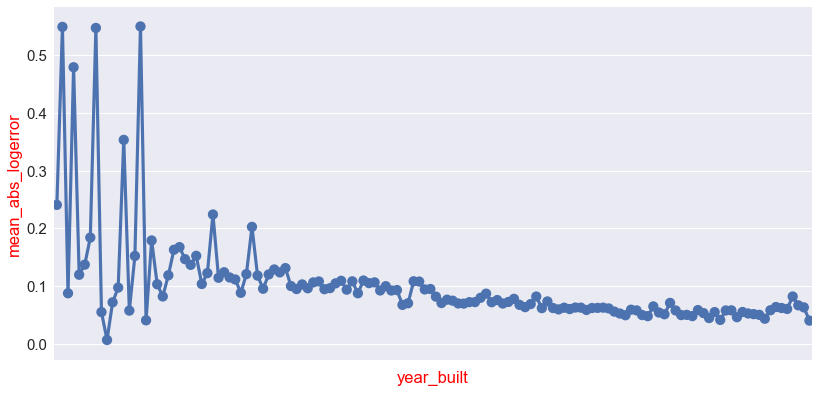

In [130]:
plt.figure(figsize=(8, 6))
g = sns.factorplot(x = 'yearbuilt', y= 'abs_logerror', data= merge_df, estimator= np.mean, size = 6, aspect=2, ci = None)
sns.set(font_scale=1.5)
g.set_axis_labels("year_built", "mean_abs_logerror")
g.set_xticklabels(labels =[])
g.set_xlabels(color ='red')
g.set_ylabels(color ='red')


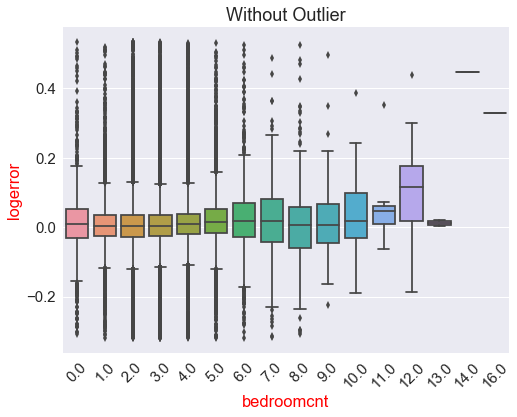

In [131]:
plt.figure(figsize=(8, 6))
g = sns.boxplot(x = nomerge_df['bedroomcnt'], y= nomerge_df['logerror'])
sns.set(font_scale=1.5)
g.set_xlabel(g.get_xlabel(), color = 'red')
g.set_ylabel(g.get_ylabel(), color ='red')
g.set_title('Without Outlier')
for item in g.get_xticklabels():
    item.set_rotation(45)


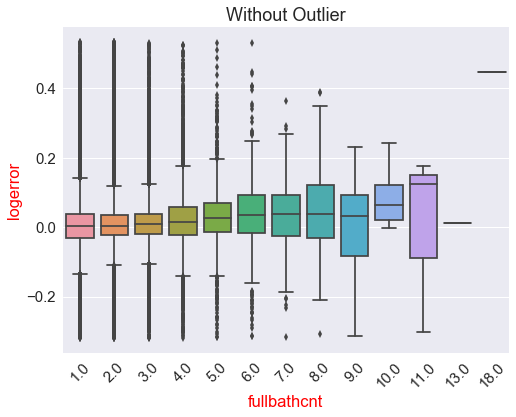

In [132]:
plt.figure(figsize=(8, 6))
g = sns.boxplot(x = nomerge_df['fullbathcnt'], y= nomerge_df['logerror'])
sns.set(font_scale=1.5)
g.set_xlabel(g.get_xlabel(), color = 'red')
g.set_ylabel(g.get_ylabel(), color ='red')
g.set_title('Without Outlier')
for item in g.get_xticklabels():
    item.set_rotation(45)


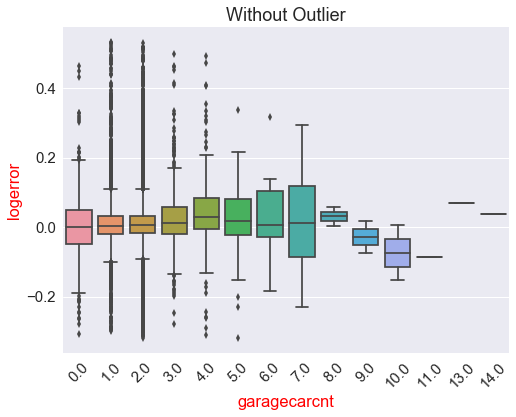

In [133]:
plt.figure(figsize=(8, 6))
g = sns.boxplot(x = nomerge_df['garagecarcnt'], y= nomerge_df['logerror'])
sns.set(font_scale=1.5)
g.set_xlabel(g.get_xlabel(), color = 'red')
g.set_ylabel(g.get_ylabel(), color ='red')
g.set_title('Without Outlier')
for item in g.get_xticklabels():
    item.set_rotation(45)


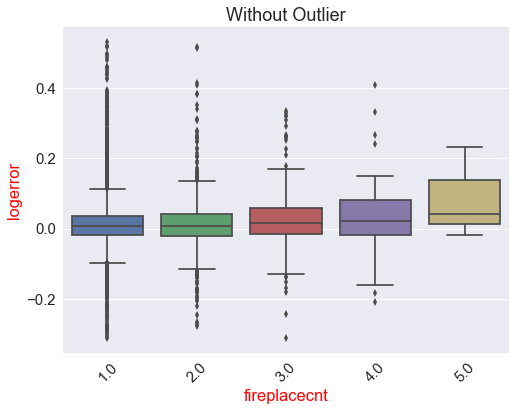

In [134]:
plt.figure(figsize=(8, 6))
g = sns.boxplot(x = nomerge_df['fireplacecnt'], y= nomerge_df['logerror'])
sns.set(font_scale=1.5)
g.set_xlabel(g.get_xlabel(), color = 'red')
g.set_ylabel(g.get_ylabel(), color ='red')
g.set_title('Without Outlier')
for item in g.get_xticklabels():
    item.set_rotation(45)


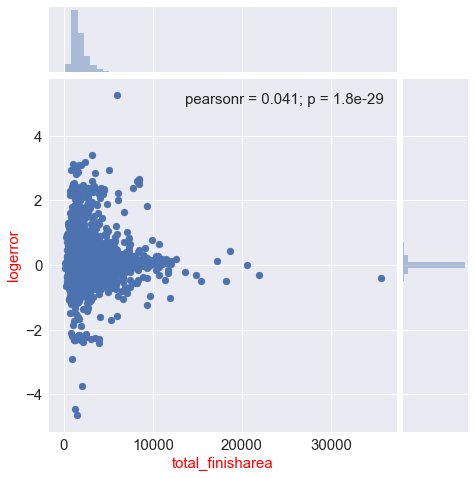

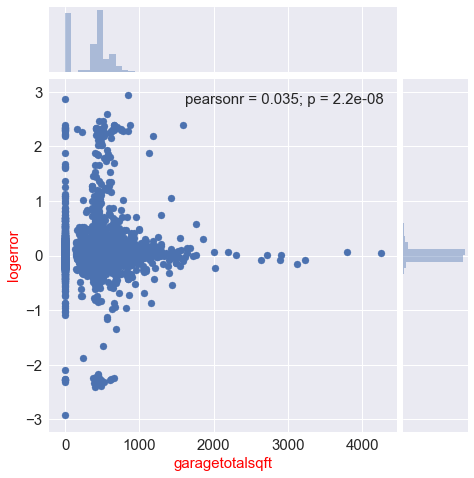

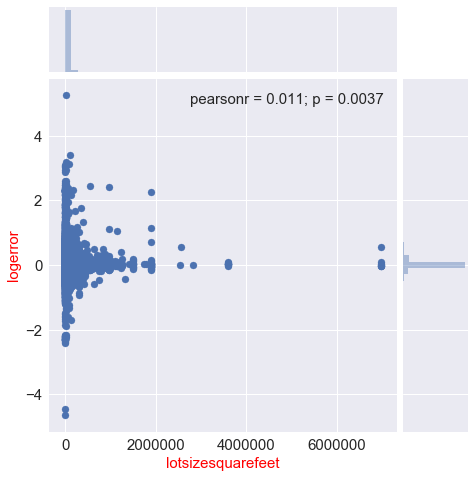

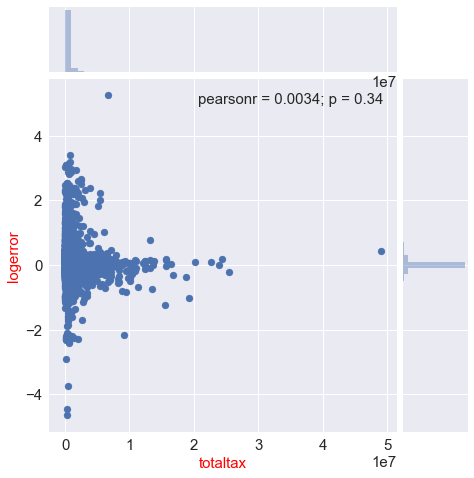

In [135]:
for feature in ['total_finisharea', 'garagetotalsqft', 'lotsizesquarefeet', 'totaltax' ]:
    a =sns.jointplot(merge_df[feature], merge_df['logerror'], size = 7, space =0.1)
    a.set_axis_labels(xlabel= feature, ylabel='logerror', color ='red', size = 15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D7E0147C88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001D72F6BE860>]], dtype=object)

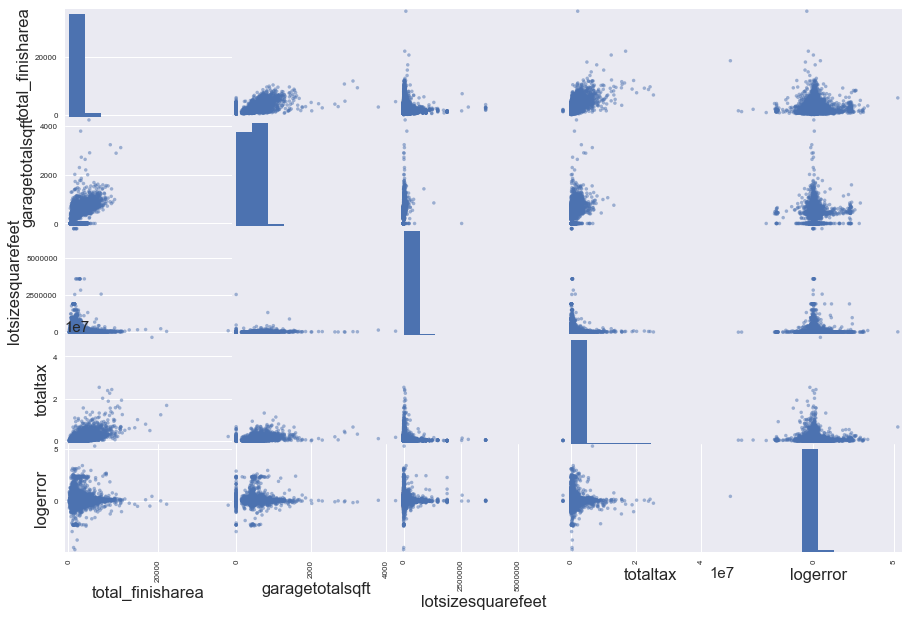

In [136]:
scatter_matrix(merge_df[['total_finisharea', 'garagetotalsqft', 'lotsizesquarefeet', 'totaltax', 'logerror']], figsize = (15,10))

##### dropping the columns with more than 68 percent of missing values and imputing the missing values with mean in the case of numerical variable and most frequent in the case of categorical variable

In [22]:
cp_merge_df = merge_df.copy()
cp_nomerge_df = nomerge_df.copy()
cp_omerge_df = omerge_df.copy()

In [23]:
merge_df.dropna(thresh=0.327*len(merge_df), axis=1, inplace=True)
nomerge_df.dropna(thresh=0.327*len(nomerge_df), axis=1, inplace=True)
omerge_df.dropna(thresh=0.327*len(omerge_df), axis=1, inplace=True)

#removing the rows which have null values (the row is removed even if it has one null value)

## impute the missing values with mean for numerical variables and mostfrequent values for categorical variables

In [24]:
imp_df =merge_df.copy()

In [25]:
for col in imp_df.columns:
    if imp_df[col].dtype  == 'float64' and col not in ('month', 'day', 'quarter'):
        imp_df[col].fillna(float(imp_df[col].mean()), inplace =True)
    if imp_df[col].dtype  == 'int64' and col not in ('month', 'day', 'quarter'):
        imp_df[col].fillna(int(imp_df[col].mean()), inplace =True)
for col in imp_df.columns:
    if imp_df[col].dtype not in ('float64', 'int64'):
        imp_df[col]= imp_df[col].astype(dtype= object)
        imp_df[col].fillna(imp_df[col].mode().values[0], inplace = True)
        imp_df[col]= imp_df[col].astype('category')

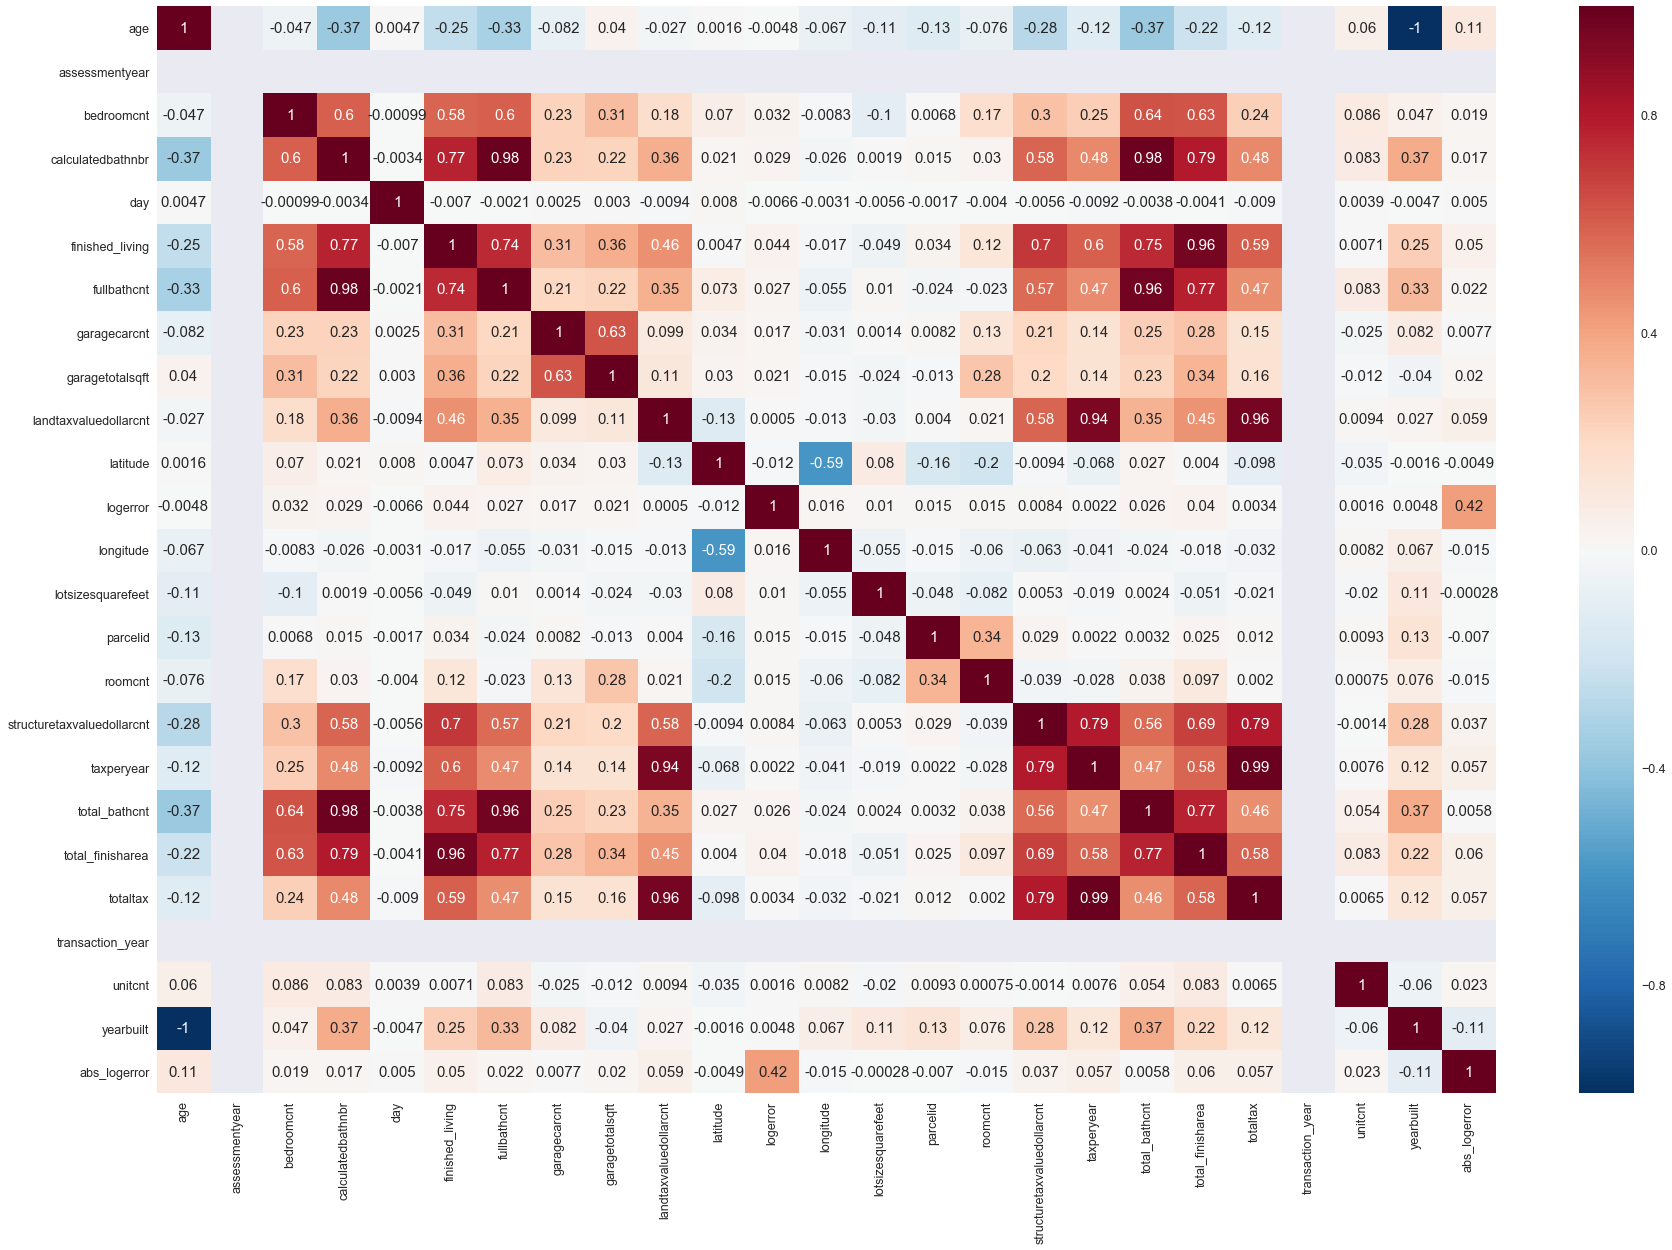

In [141]:
imp_mat = imp_df.corr()
plt.figure(figsize = (30, 20))
sns.set(font_scale = 1.25)
sns.heatmap(imp_mat, annot = True)

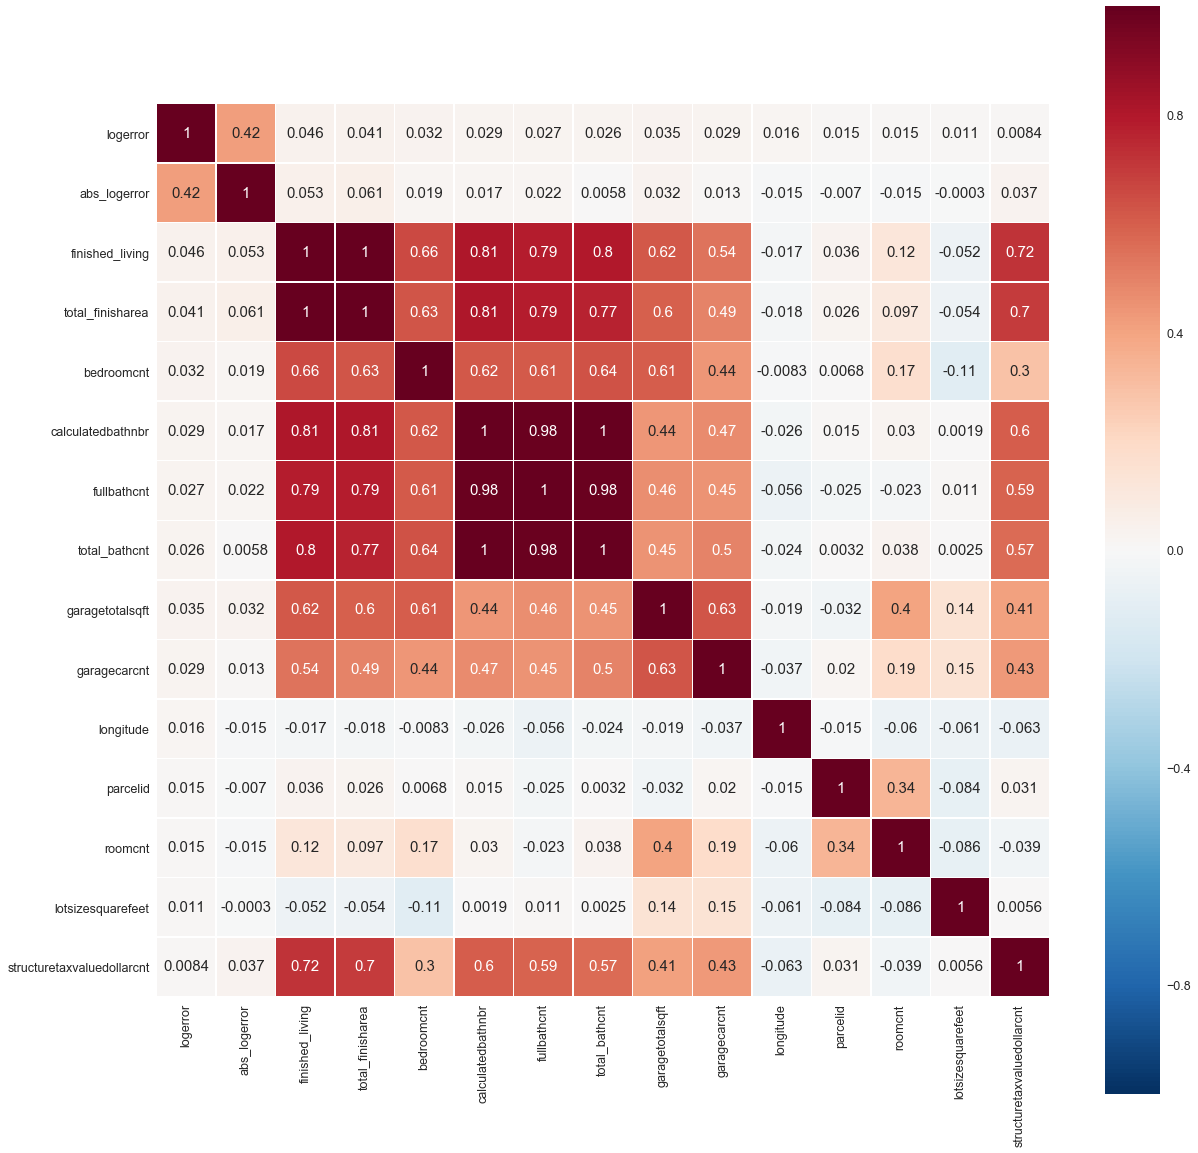

In [142]:
cols = imp_mat.nlargest(15, 'logerror')['logerror'].index
plt.figure(figsize= (20,20))
imp_mat_15 = merge_df[cols].corr()
sns.heatmap(imp_mat_15, square = True, annot=True, linewidths =0.5)
sns.set_style(style = 'darkgrid')
sns.set(font_scale = 1)

In [26]:
from sklearn.preprocessing import LabelEncoder

### Gradient Boosting Variable Importance

In [144]:
y = imp_df['logerror']
x = imp_df.drop(['logerror','abs_logerror', 'yearbuilt', 'day', 'month', 'quarter', 'transactiondate', 'parcelid'], axis=1)

for c in x.columns:
    if (x[c].dtype.name == 'category'):
        le = LabelEncoder()
        le.fit(x[c].values)
        x[c]=le.transform(x[c].values)

In [145]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0,
    'lambda':5
}

train = xgb.DMatrix(x,y)
boost_model = xgb.train(xgb_params,train,num_boost_round=150)

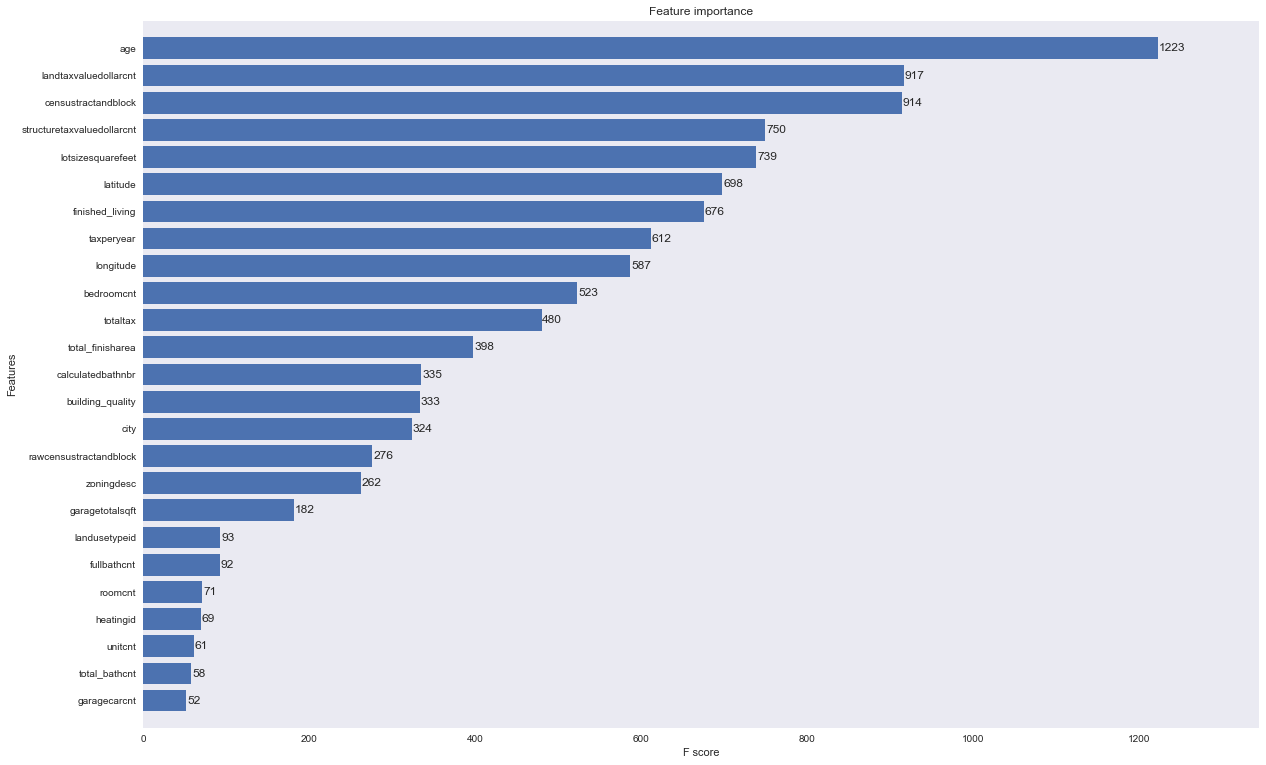

In [146]:
fig, ax = plt.subplots(1,1,figsize= (20, 13))
xgb.plot_importance(boost_model, grid = False, height= 0.8, ax=ax)

###### feature engineering with the help of  gradient boosting and correlation matrix

- finsihed_living and total_finisharea have same correlation so total_finisharea is picked
- bedroomcnt, calculatebathnbr, full_bathcnt, total_bathcnt have same correlation so bedroomcnt and total bath cnt are merged to total no of living rooms
- taxperyear, structuretax value dollar cnt, land tax value dollar count have same correlation so total tax is picked 

In [27]:
imp_df['totalroomcnt'] = imp_df['total_bathcnt'] + imp_df['bedroomcnt']

In [148]:
def funct(c):
    if (c['logerror'] > np.percentile(imp_df.logerror.values, 95)):
        val = 'positive_outlier'
    elif (c['logerror'] < np.percentile(imp_df.logerror.values, 5)):
        val ='negative_outlier'
    else:
        val = 'not_outlier'
    return val
imp_df['log_group'] = imp_df.apply(funct, axis=1)

##### Variable used for regression
- 'age', 'totalroomcnt','total_finisharea','latitude', 'longitude', 'totaltax', 'lotsizesquarefeet'

In [28]:
imp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Data columns (total 36 columns):
parcelid                      77613 non-null int64
total_bathcnt                 77613 non-null float64
bedroomcnt                    77613 non-null float64
building_quality              77613 non-null category
calculatedbathnbr             77613 non-null float64
total_finisharea              77613 non-null float64
finished_living               77613 non-null float64
fullbathcnt                   77613 non-null float64
garagecarcnt                  77613 non-null float64
garagetotalsqft               77613 non-null float64
heatingid                     77613 non-null category
latitude                      77613 non-null float64
longitude                     77613 non-null float64
lotsizesquarefeet             77613 non-null float64
landusetypeid                 77613 non-null category
zoningdesc                    77613 non-null category
rawcensustractandblock        77613 non-n

## Linear Regression

In [30]:
imp_df[['age', 'totalroomcnt','total_finisharea','latitude', 'longitude', 'totaltax', 'lotsizesquarefeet' ]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Data columns (total 7 columns):
age                  77613 non-null float64
totalroomcnt         77613 non-null float64
total_finisharea     77613 non-null float64
latitude             77613 non-null float64
longitude            77613 non-null float64
totaltax             77613 non-null float64
lotsizesquarefeet    77613 non-null float64
dtypes: float64(7)
memory usage: 4.7 MB


In [31]:
X = imp_df[['age', 'totalroomcnt','total_finisharea','latitude', 'longitude', 'totaltax', 'lotsizesquarefeet']]
Y = imp_df['logerror']

#n = pd.get_dummies(imp_df.log_group)
#X = pd.concat([X, n], axis=1)
#m = pd.get_dummies(imp_df.censustractandblock)
#X = pd.concat([X, m], axis=1)
#drops = ['censustractandblock']
#X.drop(drops, inplace=True, axis=1)
X.head()

age  totalroomcnt  total_finisharea    latitude    longitude  totaltax  \
0  35.0           9.0            3760.0  34449407.0 -119254052.0  872850.0   
1  66.0           5.0            1444.0  34454169.0 -119237898.0  436157.0   
2  38.0           4.5            1698.0  34365693.0 -119448392.0  286606.0   
3  28.0           4.0             986.0  34305600.0 -119284000.0  258888.0   
4  69.0           3.0            1170.0  34278012.0 -119257047.0  592930.0   

   lotsizesquarefeet  
0        42688.00000  
1         7108.00000  
2         2588.00000  
3        29973.43701  
4         5643.00000

In [37]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
regressor = LinearRegression(normalize=False)
regressor.fit(X_train, y_train,)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [154]:
y_pred = regressor.predict(X_test)
#print('Linear Regression R squared: ', regressor.score(X_test, y_test))
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: ', lin_rmse)
print('Linear Regression AME: ', mean_absolute_error(y_pred, y_test))


Linear Regression RMSE:  0.173057429591
Linear Regression AME:  0.0708969525796


In [155]:
print('Coefficients: \n', regressor.coef_)

Coefficients: 
 [  1.44328811e-05  -1.60302881e-03   1.26306182e-05  -4.42832689e-09
   8.21271980e-09  -6.20066147e-09   1.84672058e-08]


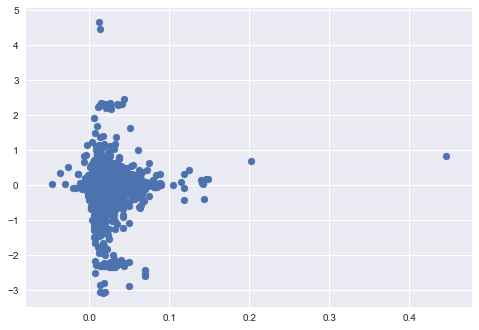

In [156]:
plt.scatter(y_pred, (y_pred- y_test))

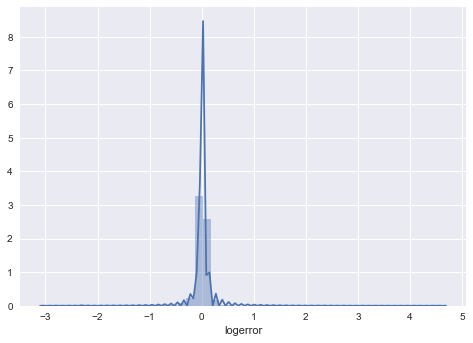

In [157]:
sns.distplot((y_pred- y_test),norm_hist=False)

# Ridge Regression

In [158]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [159]:
RMSE = []
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 100, 125, 150, 175, 200, 225, 250, 1000]
for tuning_param in alphas:
    ridge_model = Ridge(alpha=tuning_param)
    ridge_model.fit(X_train, y_train)
    ridge_model.score(X_test, y_test)
    print('Coefficients: ', tuning_param, '\n', ridge_model.coef_)
    #print(cross_val_score(ridge_model, X_train, y_train, scoring=None, cv = 5))
    RMSE.append((sum((ridge_model.predict(X_test) - y_test)**2)/len(y_test))**0.5)

Coefficients:  0.05 
 [  1.44328861e-05  -1.60302764e-03   1.26306163e-05  -4.42832743e-09
   8.21271963e-09  -6.20066116e-09   1.84672065e-08]
Coefficients:  0.1 
 [  1.44328912e-05  -1.60302646e-03   1.26306143e-05  -4.42832797e-09
   8.21271946e-09  -6.20066084e-09   1.84672072e-08]
Coefficients:  0.3 
 [  1.44329113e-05  -1.60302176e-03   1.26306065e-05  -4.42833013e-09
   8.21271877e-09  -6.20065959e-09   1.84672098e-08]
Coefficients:  1 
 [  1.44329819e-05  -1.60300531e-03   1.26305792e-05  -4.42833770e-09
   8.21271638e-09  -6.20065521e-09   1.84672189e-08]
Coefficients:  3 
 [  1.44331835e-05  -1.60295830e-03   1.26305012e-05  -4.42835934e-09
   8.21270955e-09  -6.20064268e-09   1.84672451e-08]
Coefficients:  5 
 [  1.44333852e-05  -1.60291129e-03   1.26304231e-05  -4.42838097e-09
   8.21270271e-09  -6.20063016e-09   1.84672712e-08]
Coefficients:  10 
 [  1.44338892e-05  -1.60279378e-03   1.26302281e-05  -4.42843503e-09
   8.21268563e-09  -6.20059885e-09   1.84673366e-08]
Coeff

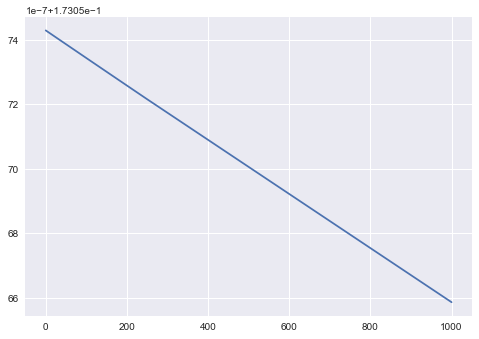

In [160]:
plt.plot(alphas, RMSE)

# Random Forest


In [161]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [162]:
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: ', forest_rmse)
print('Random Forest AME:  ', mean_absolute_error(y_pred, y_test))

Random Forest RMSE:  0.184491342476
Random Forest AME:   0.0862187977687


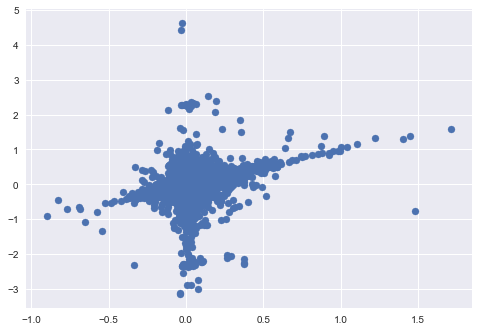

In [163]:
plt.scatter(y_pred, (y_pred- y_test))

# Gradient Boosting

In [38]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=4, min_samples_split=40, learning_rate=0.01)
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=40,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [165]:
y_pred = model.predict(X_test)
model_mse = mean_squared_error(y_pred, y_test)
model_rmse = np.sqrt(model_mse)
#print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))
print('Gradient Boosting RMSE: ', model_rmse)
print('Gradient Boosting RMSE: ', mean_absolute_error(y_pred, y_test))

Gradient Boosting RMSE:  0.173087825491
Gradient Boosting RMSE:  0.0709582747472


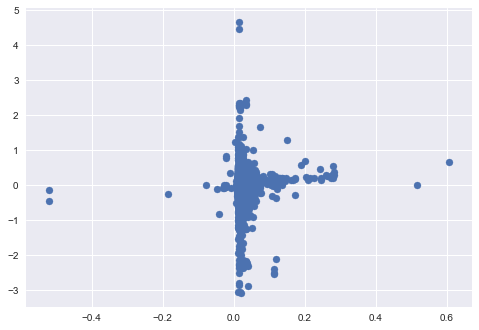

In [166]:
plt.scatter(y_pred, (y_pred- y_test))

# Cross_validation

In [51]:
from sklearn.cross_validation import cross_val_score
#Features after Cross Validation
features=['age', 'totalroomcnt','total_finisharea','latitude']
x = X[features]
gb_score=cross_val_score(model,x,Y,cv=10,scoring='mean_absolute_error')
-gb_score.mean()

0.070531605180707557

In [52]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(x, Y, test_size=0.4, random_state=0)

In [53]:
#XGB after Cross validation
model = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=4, min_samples_split=40, learning_rate=0.01)
model.fit(X1_train, Y1_train)
y_pred = model.predict(X1_test)
model_mse = mean_squared_error(y_pred, y_test)
#print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))
print('Gradient Boosting MAE: ', mean_absolute_error(y_pred, y_test))

Gradient Boosting MAE:  0.070872994978


## Principal Component Analysis

In [167]:
imp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Data columns (total 37 columns):
age                           77613 non-null float64
assessmentyear                77613 non-null float64
bedroomcnt                    77613 non-null float64
building_quality              77613 non-null category
calculatedbathnbr             77613 non-null float64
censustractandblock           77613 non-null category
city                          77613 non-null category
day                           77613 non-null int64
finished_living               77613 non-null float64
fullbathcnt                   77613 non-null float64
garagecarcnt                  77613 non-null float64
garagetotalsqft               77613 non-null float64
heatingid                     77613 non-null category
landtaxvaluedollarcnt         77613 non-null float64
landusetypeid                 77613 non-null category
latitude                      77613 non-null float64
logerror                      77613 non-

In [168]:
xyz = imp_df.copy()
xyz.drop(['parcelid','transactiondate', 
          'log_group','heatingid', 'censustractandblock', 
          'rawcensustractandblock', 'zoningdesc','assessmentyear', 'month', 'day', 'quarter', 'logerror'], axis = 1, inplace = True)

In [169]:
['parcelid','fips', 'transactiondate', 'log_group','heatingid', 'censustractandblock', 'rawcensustractandblock', 'zip', 'zoningdesc','assessmentyear', 'month', 'day', 'quarter']

['parcelid',
 'fips',
 'transactiondate',
 'log_group',
 'heatingid',
 'censustractandblock',
 'rawcensustractandblock',
 'zip',
 'zoningdesc',
 'assessmentyear',
 'month',
 'day',
 'quarter']

In [170]:
pca_data = pd.get_dummies(xyz)
pca_data['logerror']= imp_df['logerror']

In [171]:
X = pca_data.ix[:,0:len(pca_data.columns)-2].values
y = pca_data.ix[:,'logerror'].values

In [172]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [173]:
from sklearn.decomposition import PCA 
sklearn_pca = PCA(n_components=17)
Y_sklearn = sklearn_pca.fit_transform(X_std)

In [174]:
explained_variance_ratio = (sklearn_pca.explained_variance_ratio_)

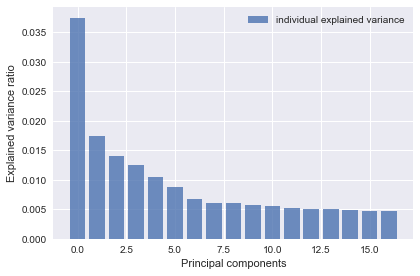

In [175]:

plt.figure(figsize=(6, 4))

plt.bar(range(17), explained_variance_ratio, alpha=0.8, align='center',
            label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

In [176]:
df = pd.DataFrame(Y_sklearn)
df.head()

0         1         2         3         4         5         6   \
0  6.532101  0.871937 -2.322546 -4.207076  3.731070  0.992800  3.300403   
1 -1.150917  0.397637  0.065959 -1.689160  4.162064  2.190263 -1.234818   
2 -1.983042 -1.064372  0.635975 -1.675033  4.077877  2.853516 -3.735214   
3 -2.062227 -2.766392  2.005733 -1.532733  3.356983  2.886738 -1.549267   
4 -1.938683  1.037194 -1.074439 -1.106763  4.995913  1.062187  0.603871   

         7         8         9         10        11        12        13  \
0  0.329490  0.712050  0.815720 -0.182628  0.693657  1.920625  0.912977   
1  0.361062  0.538251 -0.668117 -0.230844  0.907295  1.856101  0.863183   
2  0.129722 -0.527436 -0.912868 -0.021332  0.338880  0.798082 -1.455820   
3  0.486149 -0.285569 -0.012186 -0.000596  0.223115  0.910297 -1.332810   
4  0.348400  0.060293  0.106621 -0.207328  0.404033  1.155437 -1.076814   

         14        15        16  
0 -1.340465  1.032808 -1.075896  
1 -1.715471  1.059902 -0.988994  
2 -1.853245 -0.073101  0.173765  
3 -1.327776 -0.130026  0.151179  
4 -1.390607 -0.078826 -0.006109

In [177]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:7], y, test_size=0.4, random_state=0)
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [178]:
y_pred = regressor.predict(X_test)
#print('Linear Regression R squared": %.4f' % regressor.score(X_test, y_test))
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: ', lin_rmse)
print('Linear Regression AME: ', mean_absolute_error(y_pred, y_test))


Linear Regression RMSE:  0.173023450596
Linear Regression AME:  0.0710140925189


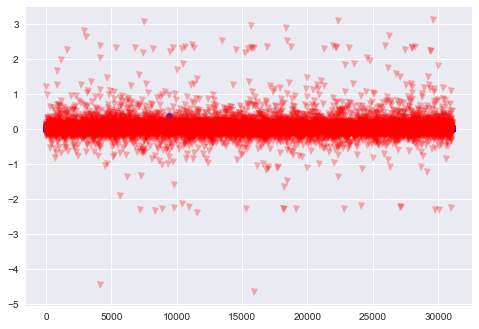

In [179]:
plt.plot(regressor.predict(X_test), 'o', color = 'blue', alpha = 0.8)
plt.plot(y_test, 'v', color ='red', alpha= 0.3)

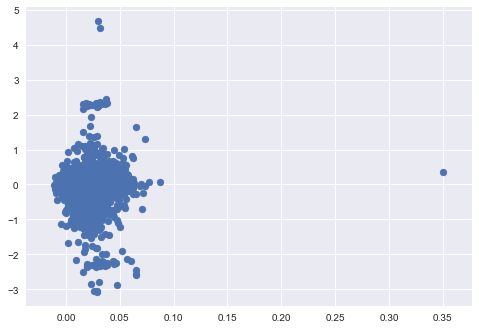

In [94]:
plt.scatter(y_pred, (y_pred- y_test))